In [1]:
# -*- coding: utf-8 -*-
import json
import matplotlib.pyplot as plt
import numpy as np
import openturns as ot

### MATPLOTLIB CONFIGURATION ###
plt.rcParams['figure.dpi']= 500
plt.rcParams['text.usetex'] = True

# Import Data

In [3]:
### DATA IMPORT ###
dataset_hl = ot.Sample.ImportFromCSVFile('../../data/SG_MC_HL.csv')

In [4]:
### TIME INDICES ### 
operation_time = np.load('../../data/SG_time.npy')

In [9]:
### INPUT VARIABLES LABELS ###
labels = [r'$\alpha$',
          r'$\beta$',
          r'$\epsilon_{e}$',
          r'$\epsilon_{c}$', 
          r'$d_{p}$',
          r'$\Gamma_{p}(0)$',
          r'$a_{v}$']

In [5]:
### INPUT SAMPLE ###
inputSample = dataset_hl[:,0:7]

In [6]:
### OUTPUT SAMPLE ###
outputSample = dataset_hl[:,7:]

In [7]:
### PARAMETERS OF THE STEAM GENERATOR ###
input_dic = {}
input_dic['SG'] = json.load(open('../../data/SG_cleaning_conditioning.json'))

In [8]:
### NEW COLOR SCHEME FOR CHEMICAL CONDITIONING ###
colors_n_chem_cond = {'C1': {'name': r'$\chi_{1}$', 'low': 'gainsboro', 'high': 'silver'},
                      'C2': {'name': r'$\chi_{2}$', 'high': 'darkgray'}}

In [72]:
labels = [
    r"$\alpha$",
    r"$\beta$",
    r"$\epsilon_e$",
    r"$\epsilon_c$",
    r"$d_p$",
    r"$\Gamma_{p}(0)$",
    r"$a_v$"
]

# 4. Kernel-based given-data sensitivity analysis

## General $R^2_{HSIC}$

In [17]:
hsic_time_HL = []
p_values_HL = []
#U-statistic is better optimized in OpenTURNS for HSIC
estimatorType_u = ot.HSICUStat() 

In [11]:
for i in range(75):
    
    tauSample_HL = outputSample[:,i]

    covarianceModelCollection_HL = []
    for i in range(7):
        Xi = inputSample.getMarginal(i)
        Cov = ot.SquaredExponential(1) #Use of squared exponential (Gaussian) kernel
        Cov.setScale(Xi.computeStandardDeviation())
        covarianceModelCollection_HL.append(Cov)

    covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))

    hsic_u_HL = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, estimatorType_u)

    hsic_time_HL.append(list(np.abs(hsic_u_HL.getR2HSICIndices())))

    #Asymptotic p-value test
    p_values_HL.append(hsic_u_HL.getPValuesAsymptotic())

In [12]:
hsic_time_HL = np.asarray(list(np.transpose(np.asarray(hsic_time_HL))))
p_values_HL = np.transpose(np.asarray(p_values_HL))

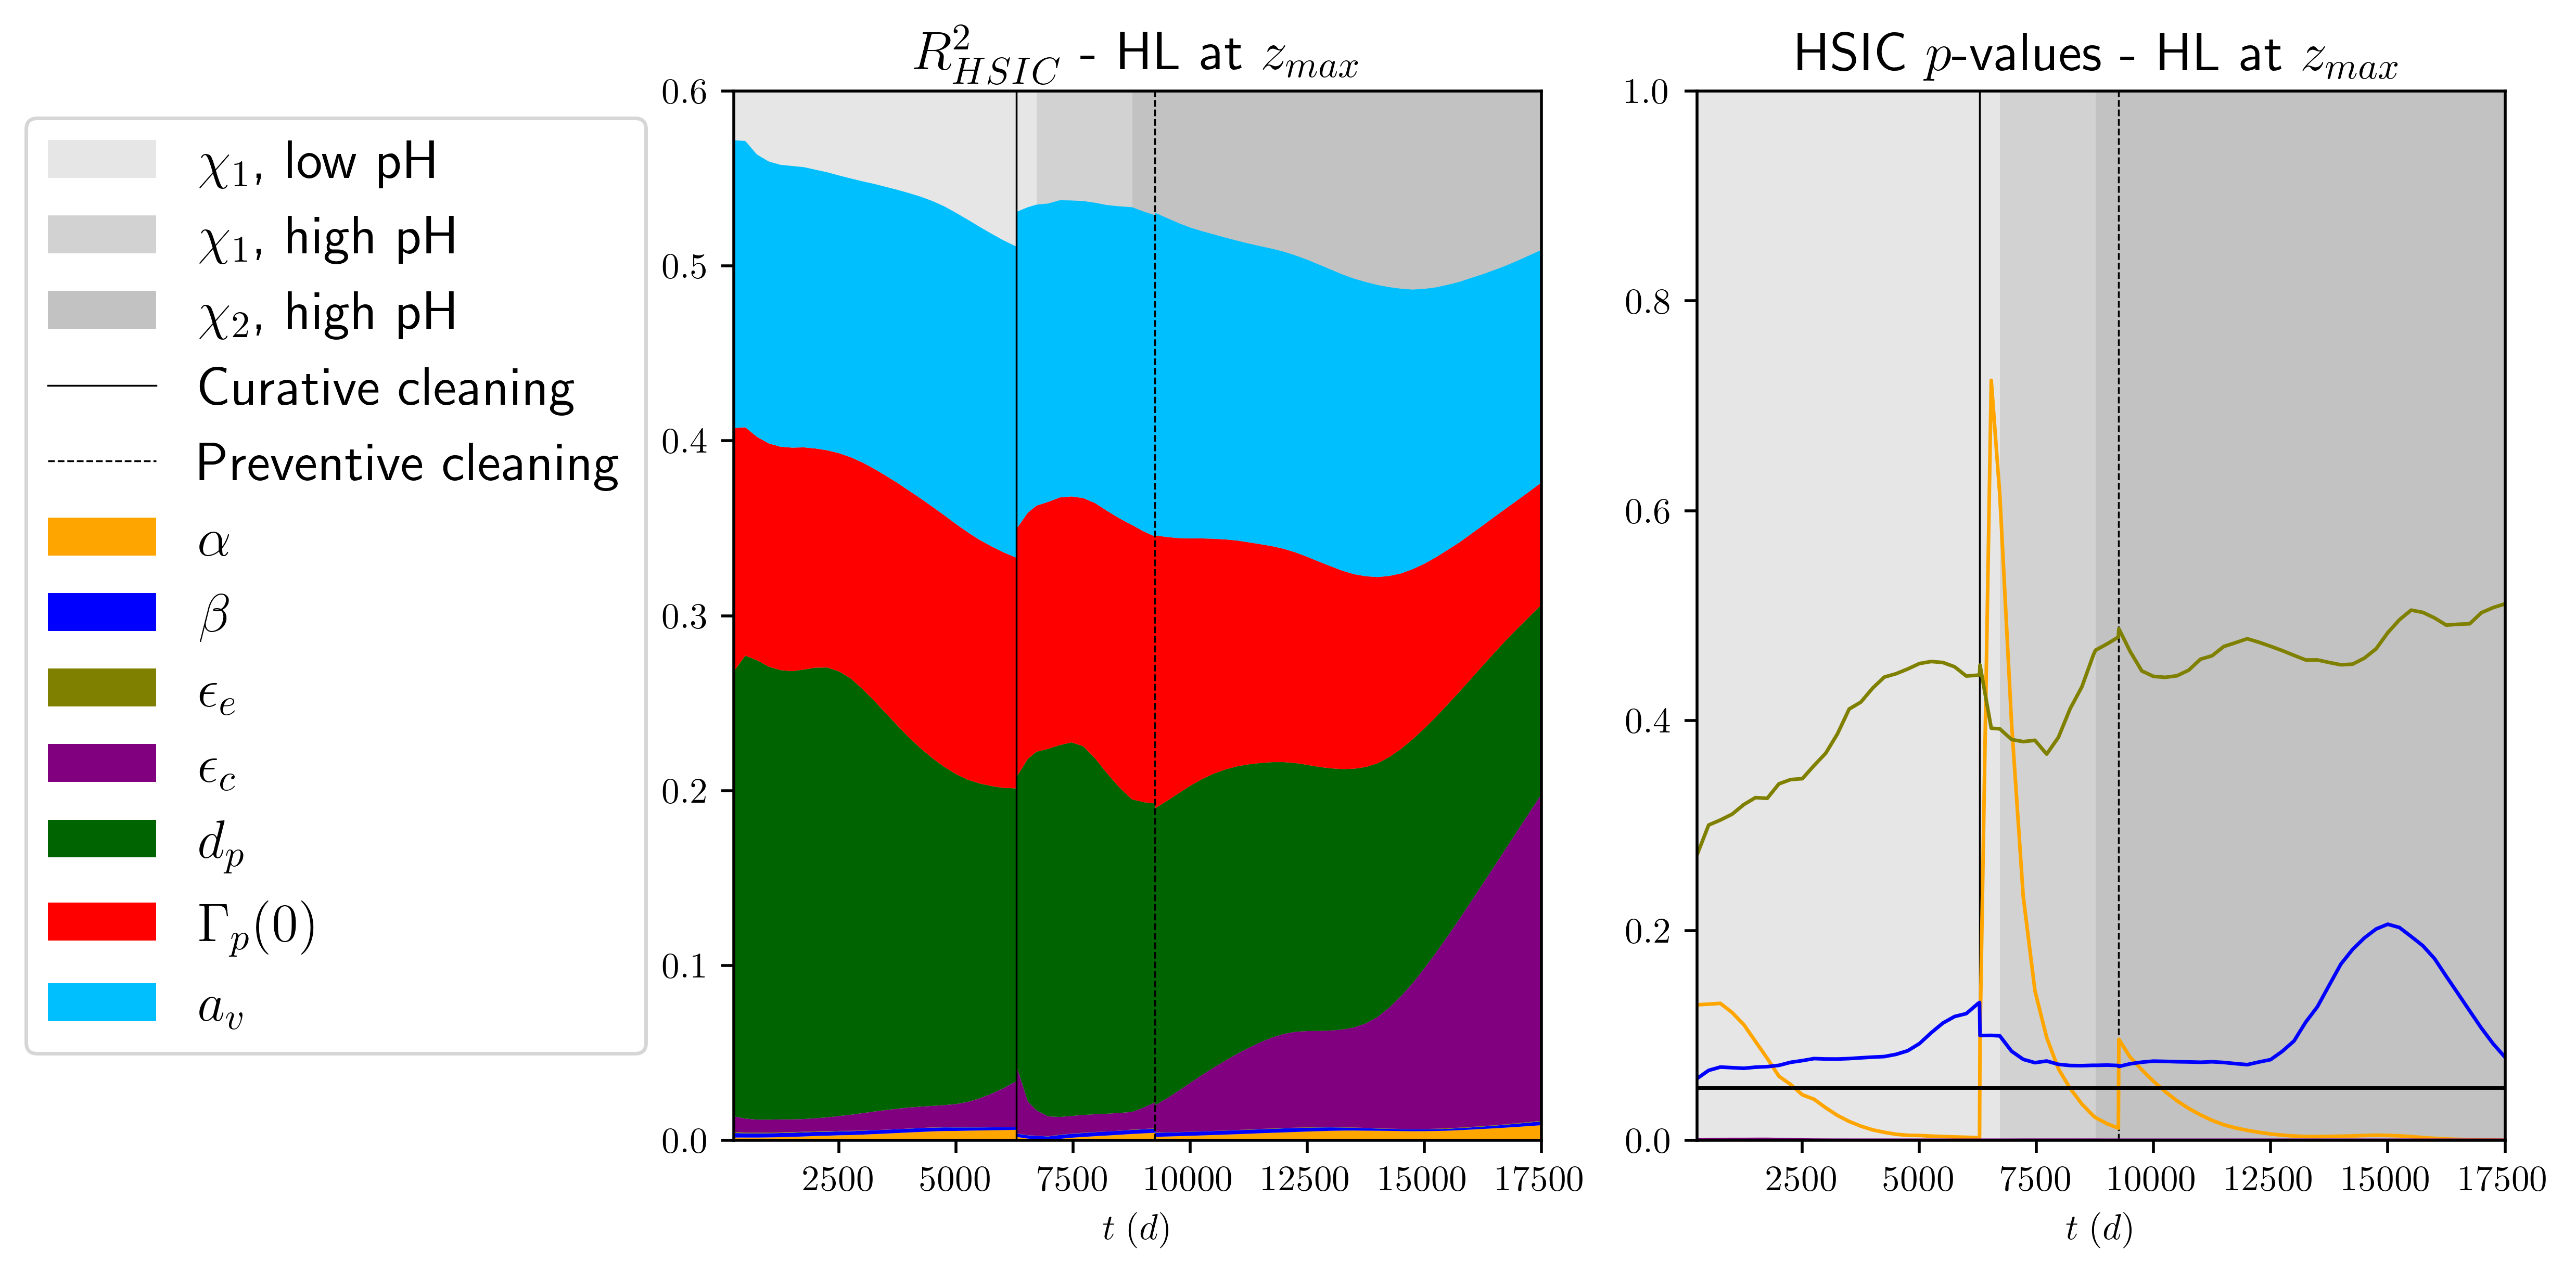

In [15]:
### FIG 10 ###

fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'darkgreen', 'red','deepskyblue']

#Chemical conditioning
cond = input_dic['SG']['chemistry']['conditioning']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['time']/24, max(operation_time)
    else:
        t_i, t_f = cond[k]['time']/24, cond[k+1]['time']/24
    c = cond[k]
    typ = colors_n_chem_cond[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, {1} pH'.format(typ['name'], c['ph']))
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha=0.7)

nett = input_dic['SG']['chemistry']['cleaning']
for k in range(len(nett)):
    if nett[k]['type'] == 'curative':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5, label='Curative cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventive':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5, label='Preventive cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0].stackplot(operation_time, hsic_time_HL, labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
axs[0].set_ylim(0,0.6)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'$R^{2}_{HSIC}$ - HL at $z_{max}$', fontsize=15)

for k in range(7):
    axs[1].plot(operation_time, p_values_HL[k], c=colors[k], linewidth=1.0)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.0)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'HSIC $p$-values - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,1.0), fontsize=15)

axs[1].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')

fig.savefig('../plots/HSIC/R2_HSIC_tot_asym.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../plots/HSIC/R2_HSIC_tot_asym.png', format='png', bbox_inches='tight')

## Target HSIC for safety threshold

In [18]:
### SAFETY LEVELS AND TARGET SET SIZE ###
tau_levels = [70]
size_dataset = []

In [19]:
hsic_target_diff_time_HL = []
p_values_target_diff_HL = []
#Use the V-stat estimator 
estimatorType_v = ot.HSICVStat() 

In [20]:
for tau in tau_levels:
    #Target levels
    dist = ot.DistanceToDomainFunction(ot.Interval(tau, float('inf')))

    hsic_target_HL = []
    p_values_target_HL = []

    size_tau = []

    for i in range(75):

        tauSample_HL = outputSample[:,i]
        sigma = tauSample_HL.computeStandardDeviation()
        func = ot.SymbolicFunction('x', 'exp(- (5 * x)/{0} )'.format(sigma))
        weight = ot.ComposedFunction(func, dist)

        covarianceModelCollection_HL = []
        
        for j in range(7):
            Xi = inputSample.getMarginal(j)
            Cov = ot.SquaredExponential(1)
            Cov.setScale(Xi.computeStandardDeviation())
            covarianceModelCollection_HL.append(Cov)

        covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))

        hsic_v_target_HL = ot.HSICEstimatorTargetSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, estimatorType_v, weight)
        
        r2_v_target_HL = hsic_v_target_HL.getR2HSICIndices()

        hsic_target_HL.append(list(np.abs(r2_v_target_HL)))

        a = np.asarray(weight(tauSample_HL))
        #An estimate of the number of points selected in the target set
        b = a[np.where(a >= 0.90)]   

        size_tau.append(b.shape[0])

        #Permutation-based test
        hsic_v_target_HL.setPermutationSize(100)
        p_values_target_HL.append(hsic_v_target_HL.getPValuesPermutation())

    size_dataset.append(size_tau)
    
    hsic_target_diff_time_HL.append(hsic_target_HL)
    p_values_target_diff_HL.append(p_values_target_HL)

hsic_target_diff_time_HL = np.asarray(hsic_target_diff_time_HL)
p_values_target_diff_HL = np.asarray(p_values_target_diff_HL)
    

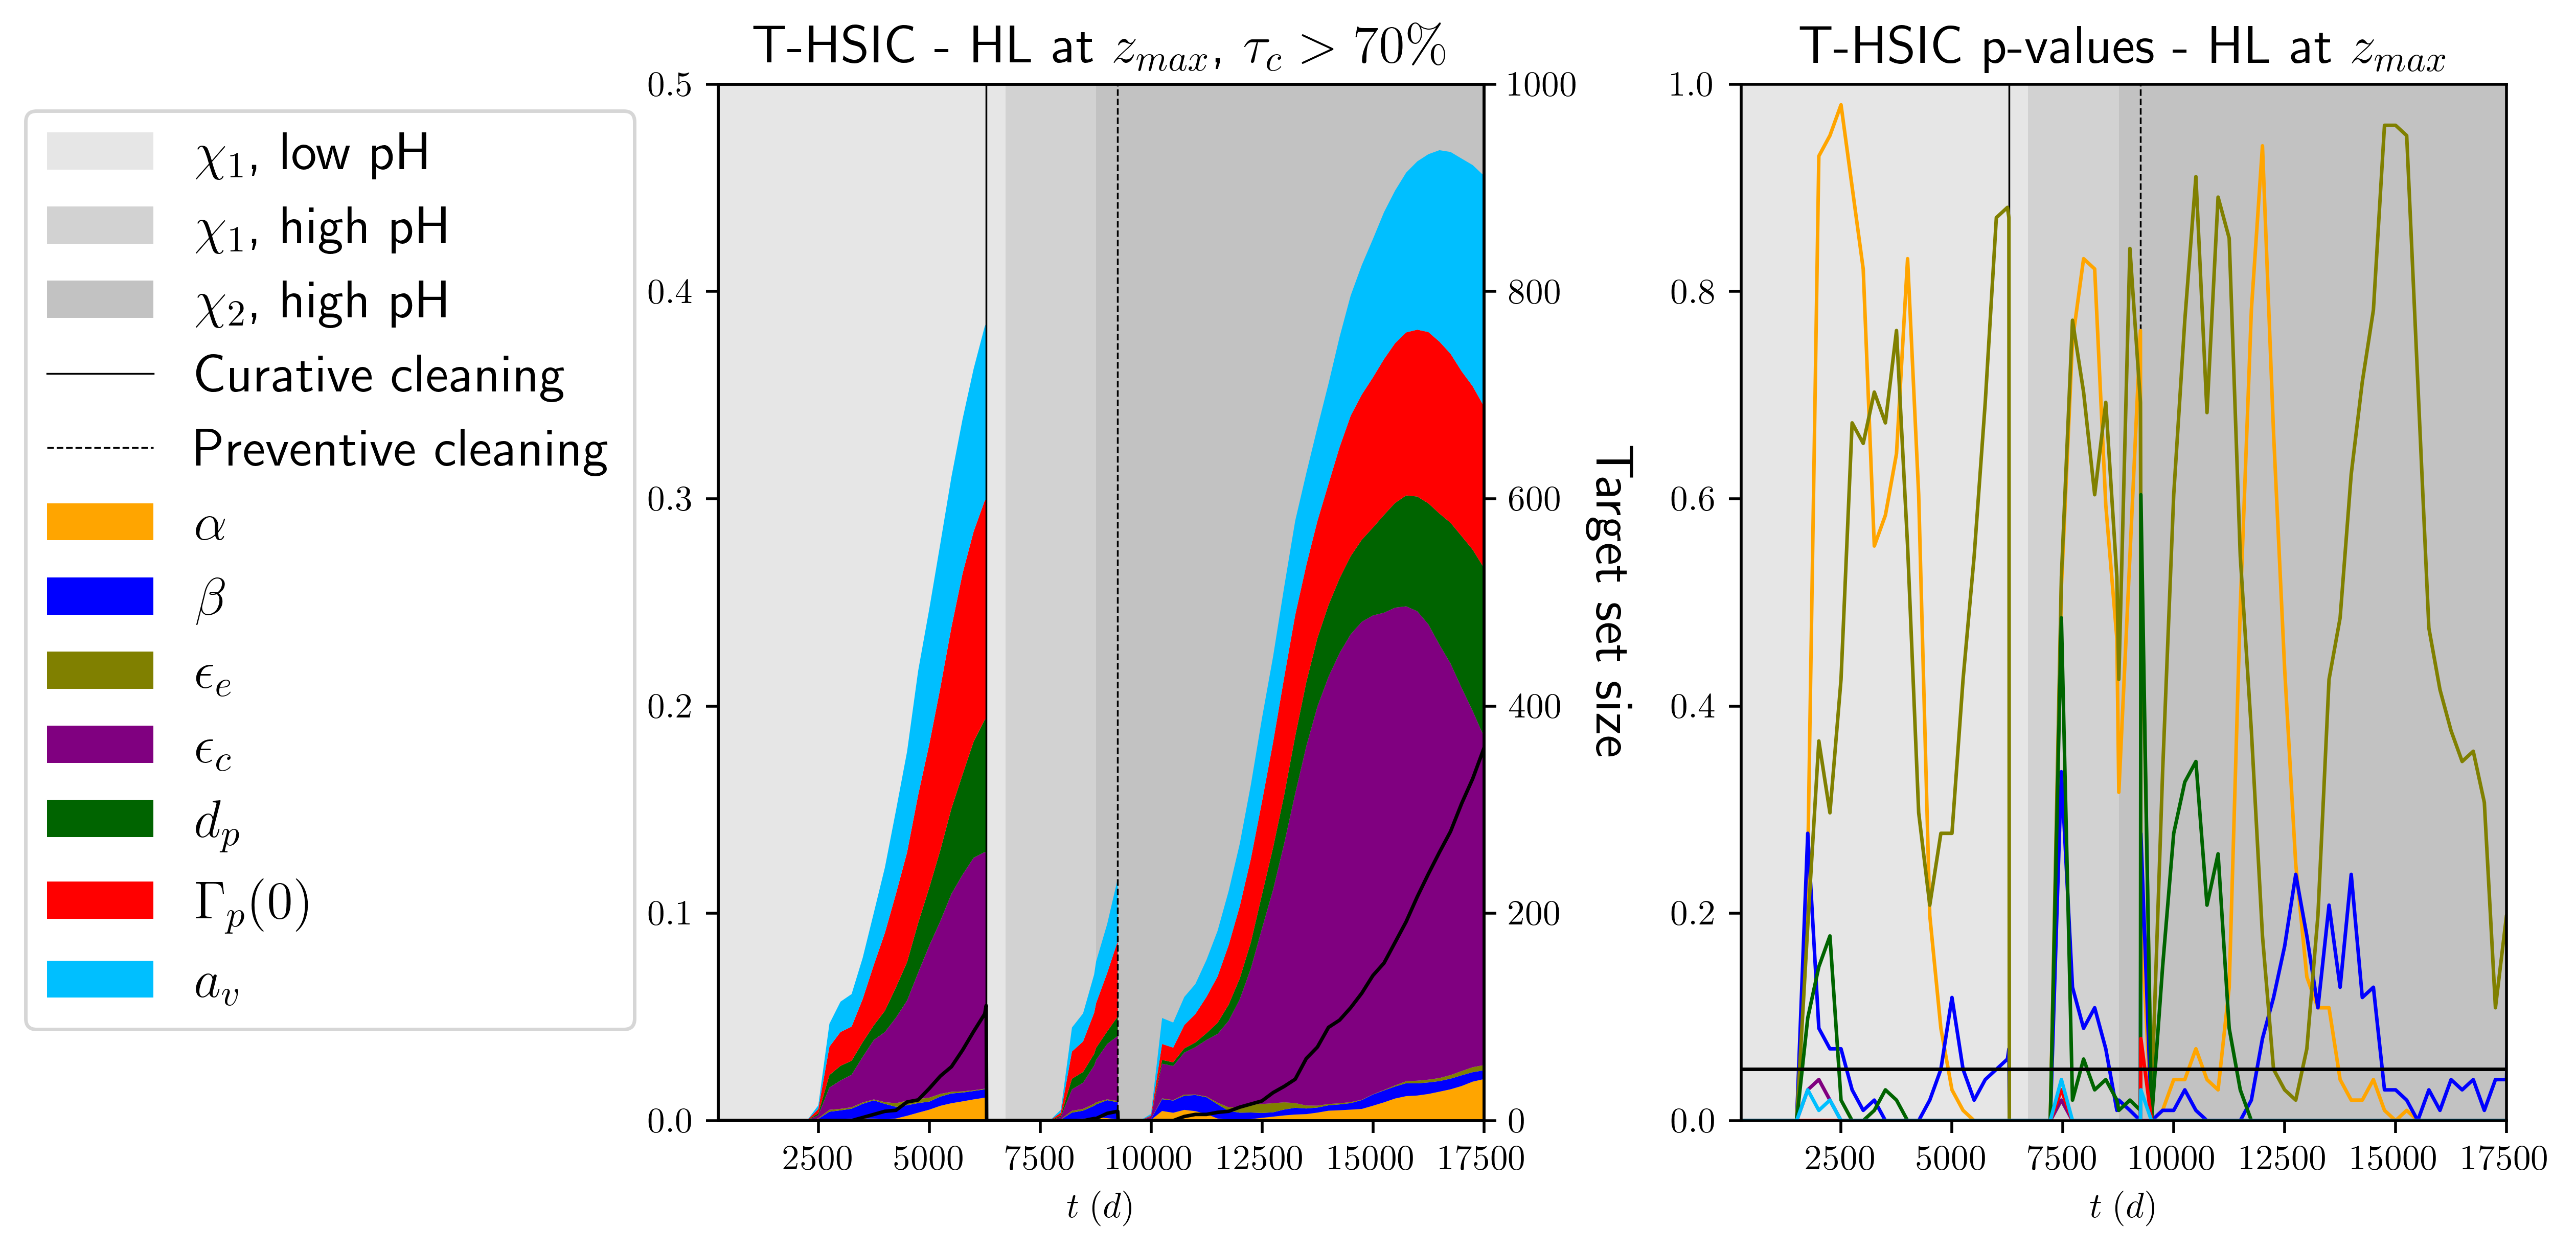

In [23]:
### FIG 11 ###

fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'darkgreen', 'red','deepskyblue']

#Chemical conditioning
cond = input_dic['SG']['chemistry']['conditioning']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['time']/24, max(operation_time)
    else:
        t_i, t_f = cond[k]['time']/24, cond[k+1]['time']/24
    c = cond[k]
    typ = colors_n_chem_cond[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, {1} pH'.format(typ['name'], c['ph']))
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha=0.7)

nett = input_dic['SG']['chemistry']['cleaning']
for k in range(len(nett)):
    if nett[k]['type'] == 'curative':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5, label='Curative cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventive':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5, label='Preventive cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5)


axs[0].stackplot(operation_time, np.transpose(hsic_target_diff_time_HL[0]), labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
axs[0].set_ylim(0,0.5)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'T-HSIC - HL at $z_{max}$, $\tau_c > 70\%$', fontsize=15)

#Target set size variation
ax_ = axs[0].twinx()
ax_.plot(operation_time, size_dataset[0], color = 'k', linewidth=1.0)
ax_.set_xlim(250,17500)
ax_.set_ylim(0,1000)
ax_.set_ylabel('Target set size', fontsize=15, rotation=270, labelpad=15)
ax_.set_ylim(0,1000)

for k in range(7):
    axs[1].plot(operation_time, np.transpose(p_values_target_diff_HL)[k], c=colors[k], linewidth=1.0)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.0)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'T-HSIC p-values - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,1.0), fontsize=15)

axs[1].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')

fig.savefig('../plots/HSIC/R2_HSIC_target.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../plots/HSIC/R2_HSIC_target.png', format='png', bbox_inches='tight')

# Conditional HSIC for different clogging levels

In [26]:
hsic_cond_diff_time_HL = []
p_values_cond_diff_HL = []
#Use of V-stat only here
estimatorType_v = ot.HSICVStat() 

In [27]:
for tau in tau_levels:
    #Target levels
    dist = ot.DistanceToDomainFunction(ot.Interval(tau, float('inf')))

    hsic_cond_HL = []
    p_values_cond_HL = []

    size_tau = []

    for i in range(75):

        tauSample_HL = outputSample[:,i]
        sigma = tauSample_HL.computeStandardDeviation()
        func = ot.SymbolicFunction('x', 'exp(- (5 * x)/{0} )'.format(sigma))
        weight = ot.ComposedFunction(func, dist)

        covarianceModelCollection_HL = []
        
        for j in range(7):
            Xi = inputSample.getMarginal(j)
            Cov = ot.SquaredExponential(1)
            Cov.setScale(Xi.computeStandardDeviation())
            covarianceModelCollection_HL.append(Cov)

        covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))

        hsic_v_cond_HL = ot.HSICEstimatorConditionalSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, weight)
        
        r2_v_cond_HL = hsic_v_cond_HL.getR2HSICIndices()

        hsic_cond_HL.append(list(np.abs(r2_v_cond_HL)))

        small_p_HL = []

        #Permutation-based test
        hsic_v_cond_HL.setPermutationSize(50)
        p_values_cond_HL.append(hsic_v_cond_HL.getPValuesPermutation())
            
    hsic_cond_diff_time_HL.append(hsic_cond_HL)
    p_values_cond_diff_HL.append(p_values_cond_HL)

hsic_cond_diff_time_HL = np.asarray(hsic_cond_diff_time_HL)
p_values_cond_diff_HL = np.transpose(np.asarray(p_values_cond_diff_HL))
    

In [28]:
### SELECT ONLY THE INFLUENT VARIABLES FOR THE P-VALUE PLOT ###
p_values_cond_influent = p_values_cond_diff_HL[3:,:,:]

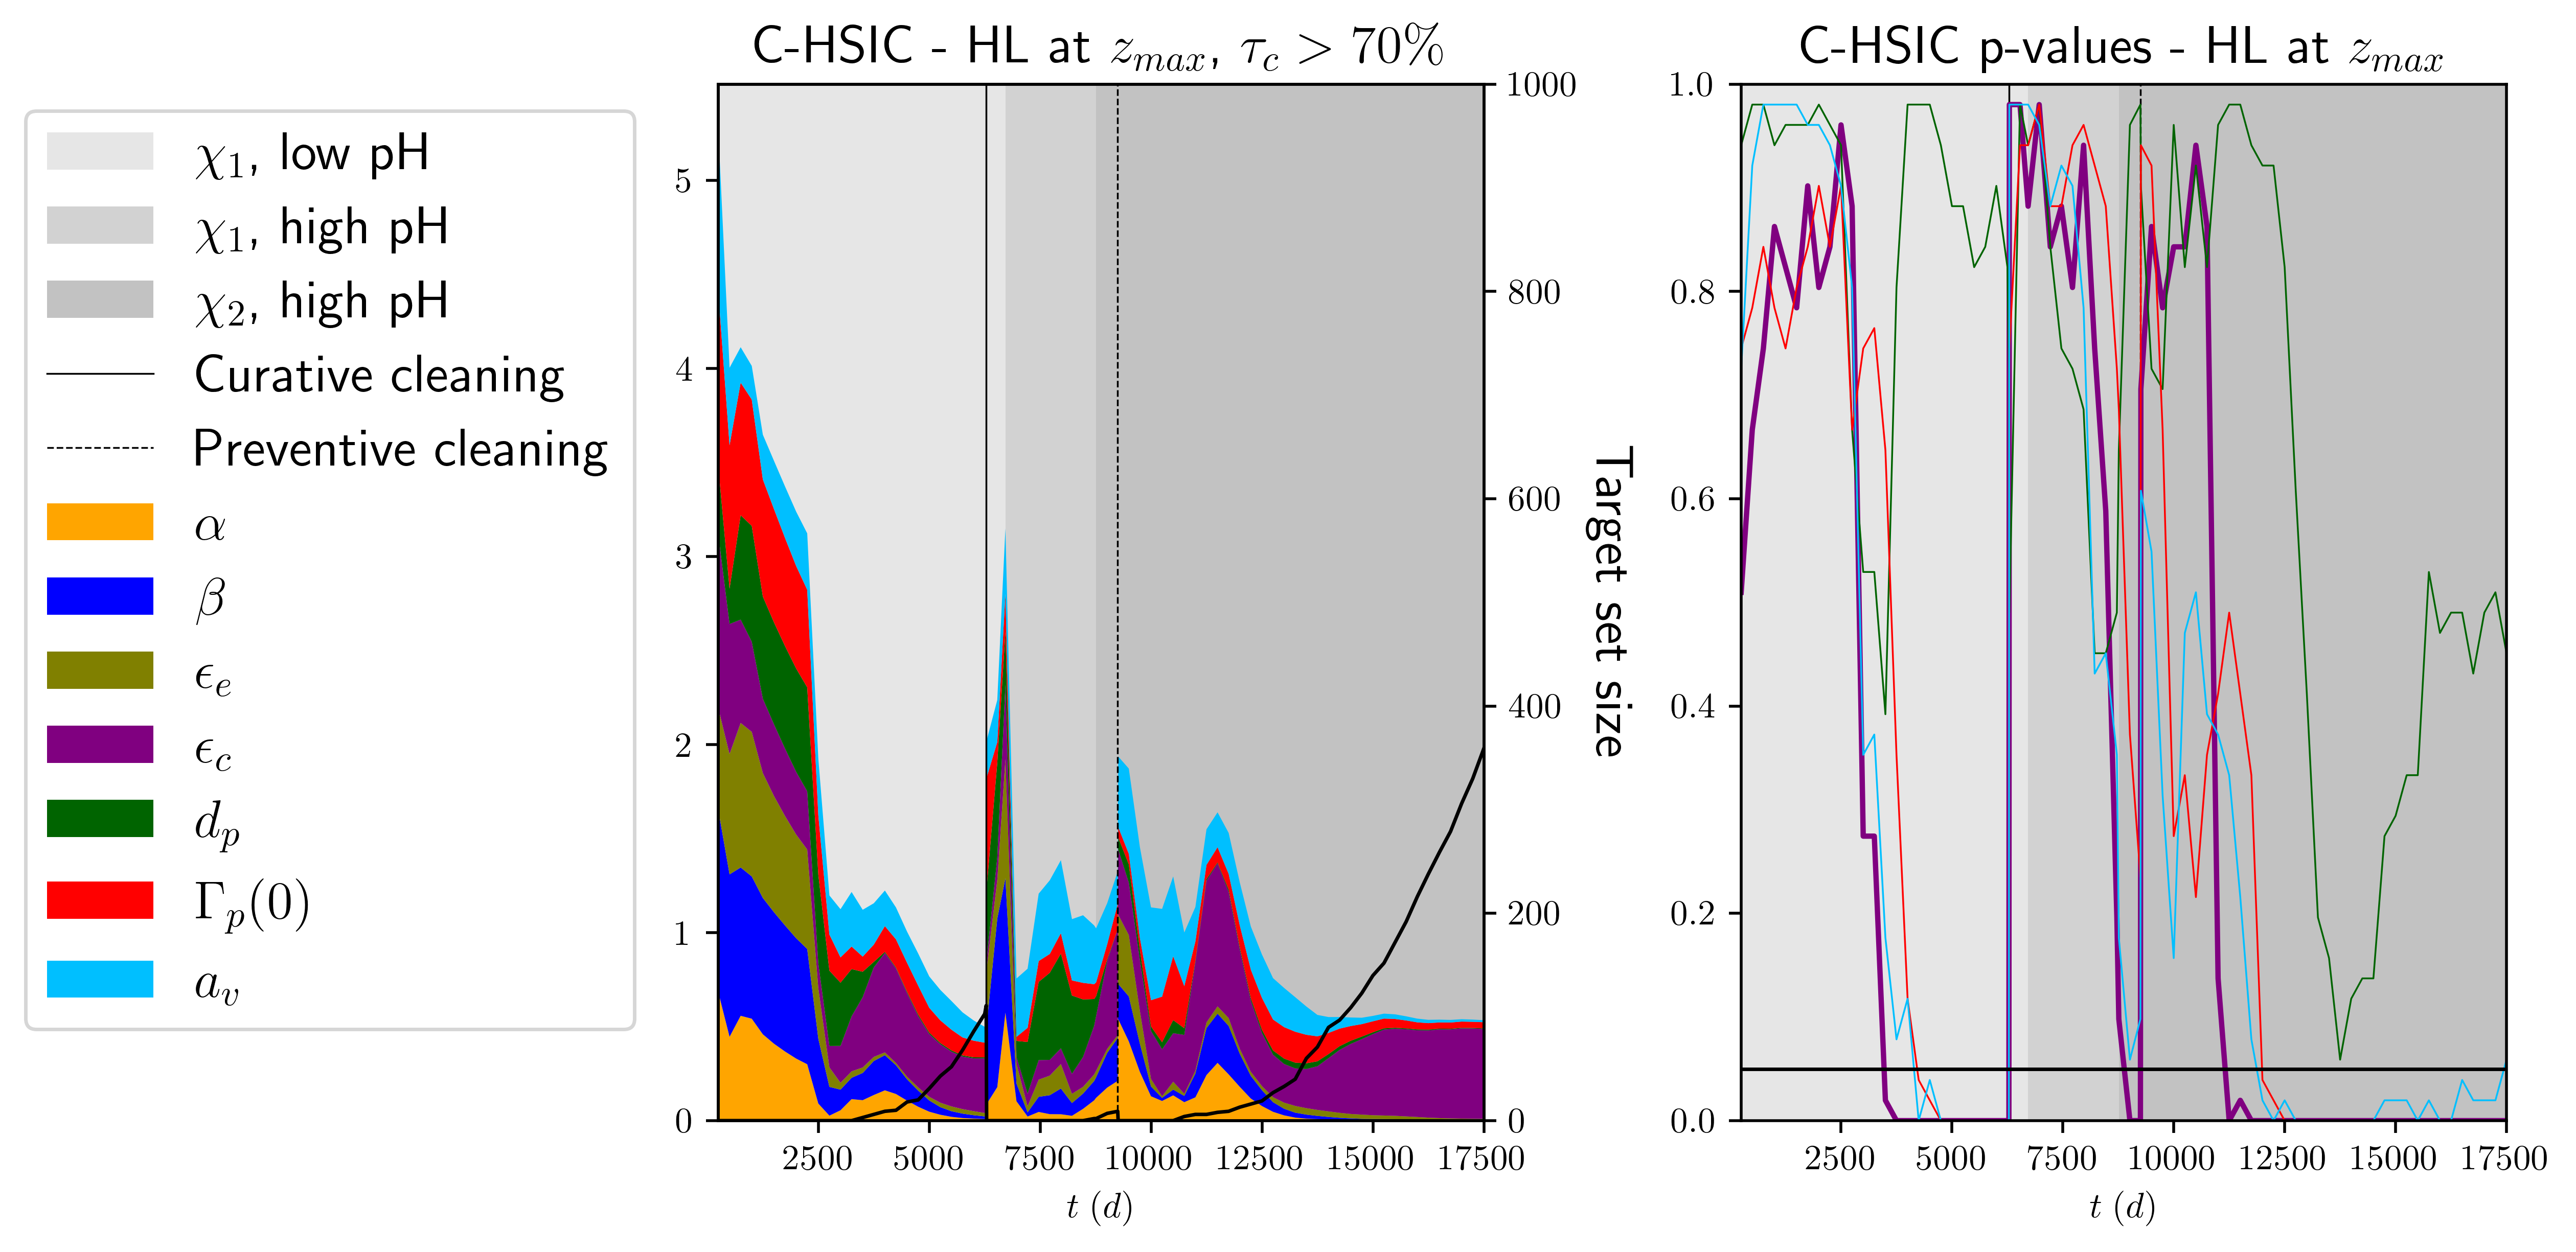

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'darkgreen', 'red','deepskyblue']

#Chemical conditioning
cond = input_dic['SG']['chemistry']['conditioning']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['time']/24, max(operation_time)
    else:
        t_i, t_f = cond[k]['time']/24, cond[k+1]['time']/24
    c = cond[k]
    typ = colors_n_chem_cond[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, {1} pH'.format(typ['name'], c['ph']))
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha=0.7)

nett = input_dic['SG']['chemistry']['cleaning']
for k in range(len(nett)):
    if nett[k]['type'] == 'curative':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5, label='Curative cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventive':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5, label='Preventive cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0].stackplot(operation_time, np.transpose(hsic_cond_diff_time_HL[0]), labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
#axs[0].set_ylim(0,0.5)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'C-HSIC - HL at $z_{max}$, $\tau_c > 70\%$', fontsize=15)

ax_ = axs[0].twinx()
ax_.plot(operation_time, size_dataset[0], color = 'k', linewidth=1.0)
ax_.set_xlim(250,17500)
ax_.set_ylim(0,1000)
ax_.set_ylabel('Target set size', fontsize=15, rotation=270, labelpad=15)
ax_.set_ylim(0,1000)

for k in range(4):
    if k == 0:
        axs[1].plot(operation_time, p_values_cond_influent[k], c=colors[k+3], linewidth=1.5)
    else:   
        axs[1].plot(operation_time, p_values_cond_influent[k], c=colors[k+3], linewidth=0.5)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.0)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'C-HSIC p-values - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,1.0), fontsize=15)

axs[1].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')

fig.savefig('../plots/HSIC/R2_HSIC_cond.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../plots/HSIC/R2_HSIC_cond.png', format='png', bbox_inches='tight')